Loaded train.csv. Shape: (90751, 55)
Loaded test.csv. Shape: (80241, 53)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80241 entries, 0 to 80240
Data columns (total 57 columns):
channelGrouping                                      80241 non-null object
date                                                 80241 non-null datetime64[ns]
fullVisitorId                                        80241 non-null object
sessionId                                            80241 non-null object
socialEngagementType                                 80241 non-null object
visitId                                              80241 non-null int64
visitNumber                                          80241 non-null int64
visitStartTime                                       80241 non-null int64
device.browser                                       80241 non-null object
device.browserSize                                   80241 non-null object
device.browserVersion                                80241 non-

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.71282
[100]	valid_0's rmse: 1.70203
[150]	valid_0's rmse: 1.6981
[200]	valid_0's rmse: 1.70048
Early stopping, best iteration is:
[157]	valid_0's rmse: 1.69703
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.79557
[100]	valid_0's rmse: 1.76165
[150]	valid_0's rmse: 1.75385
[200]	valid_0's rmse: 1.75134
Early stopping, best iteration is:
[184]	valid_0's rmse: 1.7508
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.62394
[100]	valid_0's rmse: 1.59924
[150]	valid_0's rmse: 1.59783
Early stopping, best iteration is:
[115]	valid_0's rmse: 1.59712
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.6688
[100]	valid_0's rmse: 1.64621
Early stopping, best iteration is:
[99]	valid_0's rmse: 1.64573
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.67353
[100]	valid_0's rms

NameError: name 'train_X' is not defined

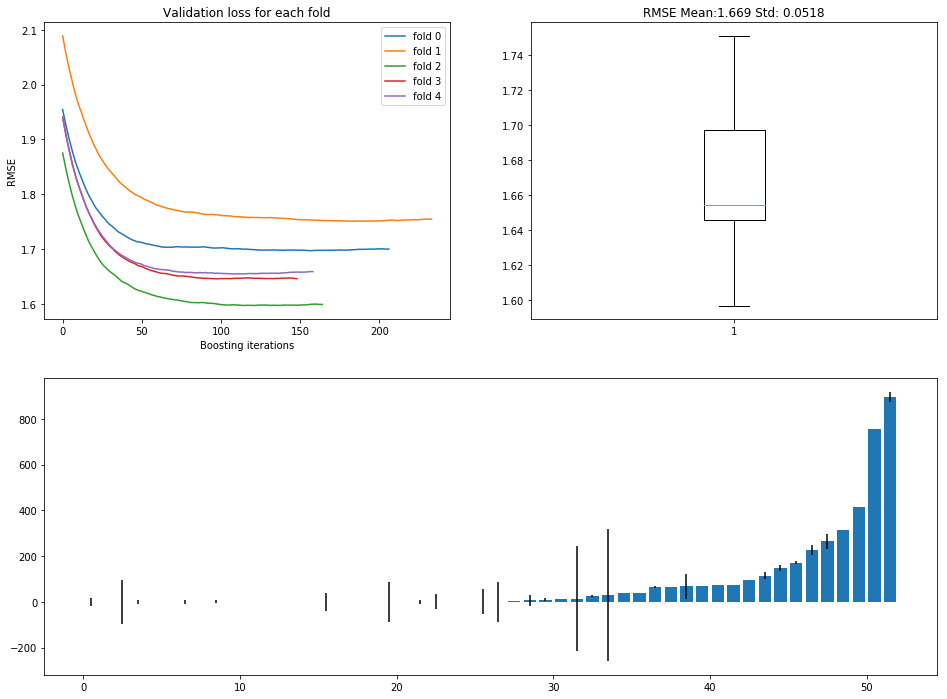

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

from pandas.io.json import json_normalize
import json
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix,classification_report

def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    p = 0.1
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     skiprows=lambda i: i>0 and random.random() > p)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {}. Shape: {}".format(os.path.basename(csv_path), df.shape))
    return df

train_data = load_df()
test_data = load_df('data/test.csv')

shops_or_not = lambda x : x.total

train_data['fullVisitorId'].nunique()

train_data["totals.transactionRevenue"] = train_data["totals.transactionRevenue"].astype('float')
y_clf = (train_data['totals.transactionRevenue'].fillna(0) > 0).astype(np.uint8)
y_reg = train_data['totals.transactionRevenue'].fillna(0)

y_clf.describe()
y_clf.value_counts()

y_reg.describe()

def date_format(df):
    df['date'] = pd.to_datetime(df['date'])
    df['vis_date'] = pd.to_datetime(df['visitStartTime'])
    df['sess_date_dow'] = df['vis_date'].dt.dayofweek
    df['sess_date_hours'] = df['vis_date'].dt.hour
    df['sess_date_dom'] = df['vis_date'].dt.day
date_format(train_data)
date_format(test_data)


test_data.info()

excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'non_zero_proba', 'vis_date', 'trafficSource.campaignCode'
]

categorical_features = [
    _f for _f in train_data.columns
    if (_f not in excluded_features) & (train_data[_f].dtype == 'object')
]

if 'totals.transactionRevenue' in train_data.columns:
    del train_data['totals.transactionRevenue']

if 'totals.transactionRevenue' in test_data.columns:
    del test_data['totals.transactionRevenue']
    
for f in categorical_features:
    train_data[f], indexer = pd.factorize(train_data[f])
    test_data[f] = indexer.get_indexer(test_data[f])
    
import lightgbm as lgb
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss

folds = GroupKFold(n_splits=5)

train_features = [_f for _f in train_data.columns if _f not in excluded_features]
print(train_features)
oof_clf_preds = np.zeros(train_data.shape[0])
sub_clf_preds = np.zeros(test_data.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(y_clf, y_clf, groups=train_data['fullVisitorId'])):
    trn_x, trn_y = train_data[train_features].iloc[trn_], y_clf.iloc[trn_]
    val_x, val_y = train_data[train_features].iloc[val_], y_clf.iloc[val_]
    
    clf = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=50,
        verbose=50
    )
    
    oof_clf_preds[val_] = clf.predict(val_x, num_iteration=clf.best_iteration_)[:]
    print(roc_auc_score(val_y, oof_clf_preds[val_]))
    sub_clf_preds += clf.predict_proba(test_data[train_features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
roc_auc_score(y_clf, oof_clf_preds)

def eval_metric(prediction, truth):
    print("recall:       {}".format(recall_score(prediction, truth)))
    print("precision:    {}".format(precision_score(prediction, truth)))
    print("f1_score:     {}".format(f1_score(prediction, truth)))
    print("\nconfusion_matrix:\n",confusion_matrix(prediction, truth))
    
eval_metric(oof_clf_preds,y_clf)

#print(classification_report(y_clf, oof_clf_preds))

from sklearn.metrics import precision_recall_curve
all_K_fold_results = []
precision, recall, thresholds = precision_recall_curve(y_clf, oof_clf_preds)

train_data['non_zero_proba'] = oof_clf_preds
test_data['non_zero_proba'] = sub_clf_preds

train_features = [_f for _f in train_data.columns if _f not in excluded_features] + ['non_zero_proba']
print(train_features)

oof_reg_preds = np.zeros(train_data.shape[0])
sub_reg_preds = np.zeros(test_data.shape[0])
importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds.split(y_reg, y_reg, groups=train_data['fullVisitorId'])):
    trn_x, trn_y = train_data[train_features].iloc[trn_], y_reg.iloc[trn_].fillna(0)
    val_x, val_y = train_data[train_features].iloc[val_], y_reg.iloc[val_].fillna(0)
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1,
        metric = 'rmse'
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=50
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test_data[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / folds.n_splits
    
    fold_results = {'best_iteration_' : reg.best_iteration_, 
               'best_score_' : reg.best_score_['valid_0']['rmse'], 
               'evals_result_': reg.evals_result_['valid_0']['rmse'],
               'feature_importances_' : reg.feature_importances_}

    all_K_fold_results.append(fold_results.copy())


    

results2 = pd.DataFrame(all_K_fold_results)
visualize_results(results2)    
mean_squared_error(np.log1p(y_reg.fillna(0)), oof_reg_preds) ** .5

In [13]:
def visualize_results(results):
#Utility function to plot fold loss and best model feature importance
    plt.figure(figsize=(16, 12))

    #----------------------------------------
    # Plot validation loss
    plt.subplot(2,2,1)

    for K in range(results.shape[0]):
        plt.plot(np.arange(len(results.evals_result_[K])), results.evals_result_[K], label = 'fold {}'.format(K))

    plt.xlabel('Boosting iterations')
    plt.ylabel('RMSE')
    plt.title('Validation loss for each fold')
    plt.legend()

    #----------------------------------------
    # Plot box plot of RMSE
    plt.subplot(2, 2, 2)    
    scores = results.best_score_
    plt.boxplot(scores)
    rmse_mean = np.mean(scores)
    rmse_std = np.std(scores)
    plt.title('RMSE Mean:{:.3f} Std: {:.4f}'.format(rmse_mean,rmse_std ))
    
    #----------------------------------------
    # Plot feature importance
    #feature_importance = results.sort_values('best_score_').feature_importances_[0]
    df_feature_importance = pd.DataFrame.from_records(results.feature_importances_)
    feature_importance = df_feature_importance.mean()
    std_feature_importance = df_feature_importance.std()
    
    # make importances relative to max importance
    #feature_importance = 100.0 * (mean_feature_importance / mean_feature_importance.sum())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(2, 1, 2)
    plt.bar(pos, feature_importance[sorted_idx], align='center', yerr = std_feature_importance)
    xlabels = [ train_X.columns.values[i] for i in sorted_idx]
    plt.xticks(pos, xlabels, rotation = 90)
    plt.xlabel('Feature')
    plt.ylabel('Avg Importance score')
    plt.title('Mean Feature Importance over K folds') 
    
    plt.show()

In [4]:
import lightgbm as lgb